In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 1
set_seed(seed)

# **1. Sentiment Analysis for Financial News**

# **Data**

In [3]:
data_path = '/kaggle/input/aio-module6-w3-dataset/weatherHistory/weatherHistory.csv'
df = pd.read_csv(data_path)
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [4]:
df['Temperature (C)']

0         9.472222
1         9.355556
2         9.377778
3         8.288889
4         8.755556
           ...    
96448    26.016667
96449    24.583333
96450    22.038889
96451    21.522222
96452    20.438889
Name: Temperature (C), Length: 96453, dtype: float64

In [5]:
dataset_df = pd.DataFrame(data=df['Temperature (C)'].tolist(), index=df['Formatted Date'].tolist(), columns=['temperature'])
dataset_df

,temperature
2006-04-01 00:00:00.000 +0200,9.472222
2006-04-01 01:00:00.000 +0200,9.355556
2006-04-01 02:00:00.000 +0200,9.377778
2006-04-01 03:00:00.000 +0200,8.288889
2006-04-01 04:00:00.000 +0200,8.755556
...,...
2016-09-09 19:00:00.000 +0200,26.016667
2016-09-09 20:00:00.000 +0200,24.583333
2016-09-09 21:00:00.000 +0200,22.038889
2016-09-09 22:00:00.000 +0200,21.522222


In [6]:
def slicing_window(df, start_index, end_index, input_size, label_size, offset):
    features = []
    labels = []
    window_size = input_size + offset

    if end_index == None:
        end_index = len(df) - (input_size + offset + label_size)
        
    for i in range(start_index, end_index):
        
        feature_start_id = i
        feature_end_id = feature_start_id + input_size
        label_start_id = i + input_size + offset - 1
        label_end_id = label_start_id + label_size
        
        if label_end_id > len(df):
            break
            
        feature = df[feature_start_id : feature_end_id].values
        label = df[label_start_id : label_end_id].values

        features.append(feature)
        labels.append(label)

    features = np.array(features)
    labels = np.array(labels)
    return features, labels
        

In [7]:
dataset_length = len(dataset_df)
val_size = 0.2
input_size = 6
label_size = 1
train_end_index = int((1 - val_size) * dataset_length)
valid_end_index = int(train_end_index + val_size * dataset_length // 2)

train_X, train_y = slicing_window(dataset_df, start_index=0, end_index=train_end_index, 
                         input_size=input_size, label_size=label_size, offset=1)

valid_X, valid_y = slicing_window(dataset_df, start_index=train_end_index, end_index=valid_end_index, 
                         input_size=input_size, label_size=label_size, offset=1)

test_X, test_y = slicing_window(dataset_df, start_index=valid_end_index, end_index=dataset_length, 
                         input_size=input_size, label_size=label_size, offset=1)

In [8]:
print('train: ', train_X.shape, train_y.shape)
print('valid: ', valid_X.shape, valid_y.shape)
print('test: ', test_X.shape, test_y.shape)

train:  (77162, 6, 1) (77162, 1, 1)
valid:  (9645, 6, 1) (9645, 1, 1)
test:  (9640, 6, 1) (9640, 1, 1)


In [9]:
train_X[0].shape

(6, 1)

***prepare data for training***

In [10]:
class WeatherDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        feature = torch.tensor(self.X[idx], dtype=torch.float32) 
        label = torch.tensor(self.y[idx], dtype=torch.float32)
        return feature, label

In [11]:
train_dataset = WeatherDataset(train_X, train_y)
valid_dataset = WeatherDataset(valid_X, valid_y)
test_dataset = WeatherDataset(test_X, test_y)

In [12]:
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [13]:
next(iter(train_loader))[0].shape

torch.Size([128, 6, 1])

# **Model: RNN**

In [14]:
!pip install torchsummary
from torchsummary import summary

In [15]:
class WeatherFocaster(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, n_classes, dropout_rate=0.0):
        super().__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.flatten = nn.Flatten()
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, n_classes)       

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :] # get final word
        x = self.flatten(x)
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [16]:
embedding_dim = 1
hidden_dim = 16
num_layers = 5
n_classes = label_size
dropout_rate=0.2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherFocaster(embedding_dim, 
                        hidden_dim, num_layers, 
                        n_classes, dropout_rate).to(device)

In [17]:
summary(model, (12,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 12, 16], [-1, 2, 16]]               0
           Flatten-2                   [-1, 16]               0
         LayerNorm-3                   [-1, 16]              32
           Dropout-4                   [-1, 16]               0
            Linear-5                    [-1, 1]              17
Total params: 49
Trainable params: 49
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


***Training***

In [18]:
def evaluate(model, dataloader, criterion, device):
    model.eval()

    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [19]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [20]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [21]:
train_losses, val_losses = fit(
    model,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    device,
    epochs
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  retu

EPOCH 1:	Train loss: 114.0904	Val loss: 49.5011
EPOCH 2:	Train loss: 54.6345	Val loss: 28.8503
EPOCH 3:	Train loss: 49.0529	Val loss: 23.5109
EPOCH 4:	Train loss: 47.9101	Val loss: 22.4292
EPOCH 5:	Train loss: 47.2386	Val loss: 20.8421
EPOCH 6:	Train loss: 46.7086	Val loss: 20.4508
EPOCH 7:	Train loss: 46.3199	Val loss: 20.1518
EPOCH 8:	Train loss: 45.8202	Val loss: 19.6440
EPOCH 9:	Train loss: 45.4908	Val loss: 19.6500
EPOCH 10:	Train loss: 45.7216	Val loss: 19.8863
EPOCH 11:	Train loss: 45.2014	Val loss: 19.4938
EPOCH 12:	Train loss: 44.9262	Val loss: 19.6528
EPOCH 13:	Train loss: 44.7694	Val loss: 20.2549
EPOCH 14:	Train loss: 44.3832	Val loss: 19.0152
EPOCH 15:	Train loss: 44.3732	Val loss: 19.0698
EPOCH 16:	Train loss: 44.5174	Val loss: 19.5745
EPOCH 17:	Train loss: 44.0490	Val loss: 18.8598
EPOCH 18:	Train loss: 43.8376	Val loss: 18.7391
EPOCH 19:	Train loss: 43.6755	Val loss: 18.8997
EPOCH 20:	Train loss: 43.3399	Val loss: 18.9852
EPOCH 21:	Train loss: 43.6710	Val loss: 18.7250


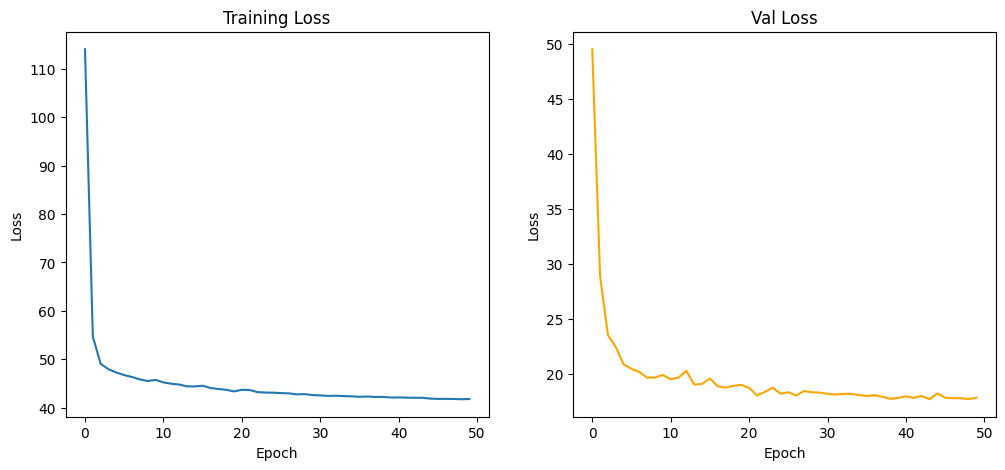

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [23]:
val_loss = evaluate(
    model,
    valid_loader,
    criterion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  17.823783773564383
Test loss:  15.828515340876283


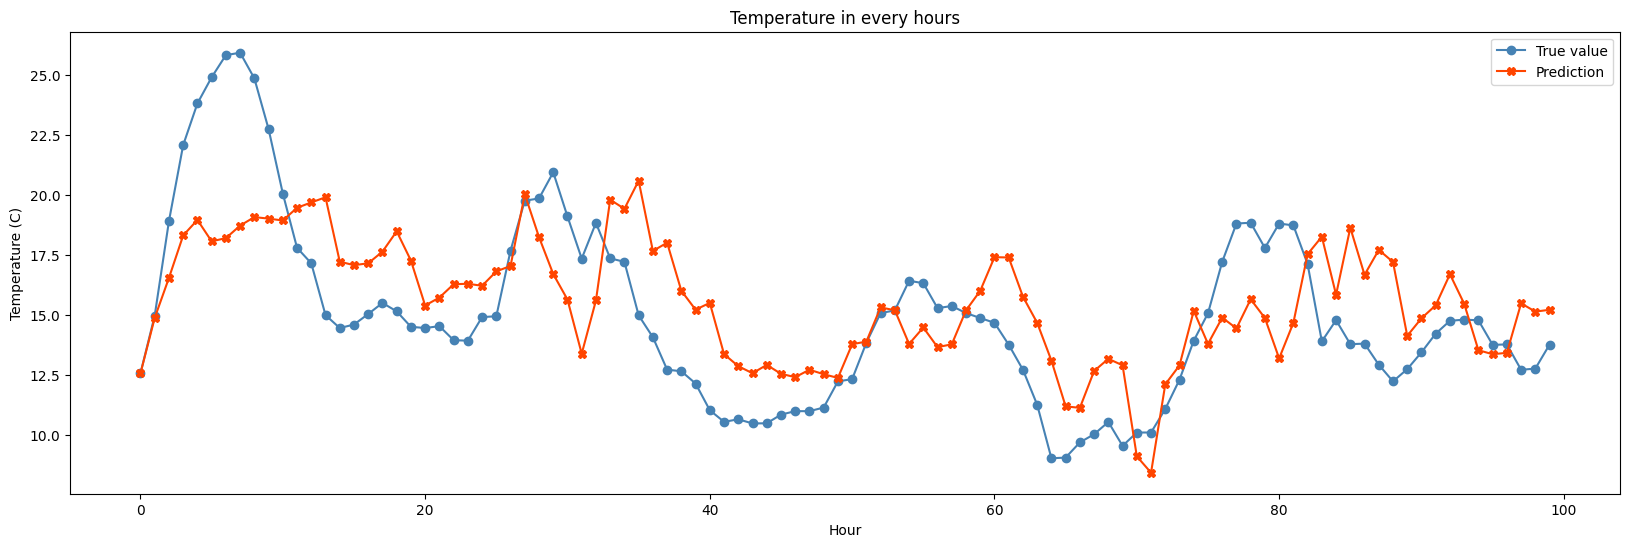

In [24]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(test_X[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()
plot_difference(test_y[:100], outputs)